In [17]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.signal as sig
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
%matplotlib inline

In [18]:
labels = pd.read_csv('data_labels\REAL-PD_Training_Data_IDs_Labels.csv')
print(labels.shape)
null = pd.read_csv('null_solution.csv')

(591, 5)


In [19]:
tremor_preds=null[["subject_id", "tremor"]]
tremor_preds=tremor_preds.rename(columns={"tremor":"tremor_null"})

In [20]:
labels=pd.merge(labels, tremor_preds, how="left", on=["subject_id"])


0.0    136
1.0    114
2.0      6
Name: dyskinesia, dtype: int64


Text(0.5, 1.0, 'Dyskinesia')

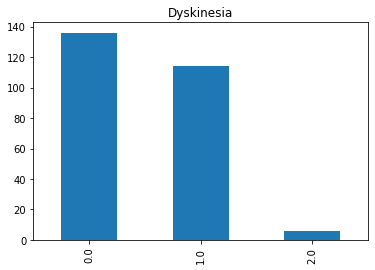

In [21]:
print(labels['dyskinesia'].value_counts())
labels['dyskinesia'].value_counts().plot(kind='bar')
plt.title('Dyskinesia')


In [22]:
labels[["on_off", "tremor", "dyskinesia"]].corr()

,on_off,tremor,dyskinesia
on_off,1.000000,0.423928,-0.082028
tremor,0.423928,1.000000,0.085026
dyskinesia,-0.082028,0.085026,1.000000


Text(0.5, 1.0, 'Tremor')

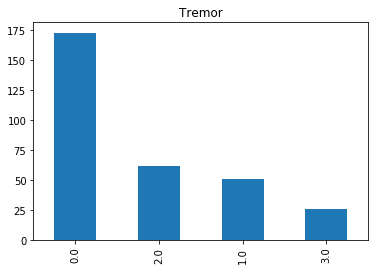

In [23]:
labels['tremor'].value_counts().plot(kind='bar')
plt.title('Tremor')

In [24]:
pd.pivot_table(labels[["subject_id","tremor"]], index="subject_id", columns=["tremor"],aggfunc=len)

tremor,0.0,1.0,2.0,3.0
subject_id,,,,
hbv012,29.0,8.0,5.0,NaN
hbv013,49.0,12.0,5.0,1.0
hbv022,45.0,6.0,5.0,NaN
hbv023,NaN,2.0,36.0,8.0
hbv038,NaN,15.0,11.0,17.0
hbv054,50.0,8.0,NaN,NaN


In [25]:
"""define frequency bands the step function"""
W_n = [3,7];

"""Select the step function"""
Ord = sig.buttord(wp = [4,6],ws =[3,7],gpass =0.08, gstop = 10,fs = 50)
Filter = sig.butter(Ord[0],Wn = W_n,btype = 'bandpass',fs =50);

Text(0.5, 0, 'Frequency[Hz]')

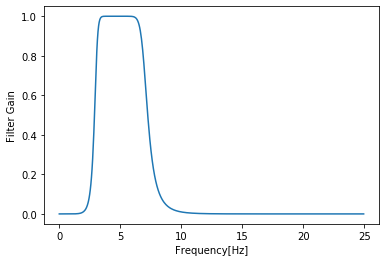

In [26]:
"""Plot the frequency response"""
Response = sig.freqz(Filter[0],Filter[1],fs=50)

plt.plot(Response[0],np.abs(Response[1]))
plt.ylabel("Filter Gain");
plt.xlabel("Frequency[Hz]")

In [79]:

#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'training_data\REAL_training\smartphone_accelerometer'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means_sa=[]
for csvfile in csvfiles:
    pre_df = pd.read_csv(csvfile)
    
    numsamples,numfeatures = pre_df.shape
    windowsize=numsamples//40
    start=0
    end=windowsize
    
    for i in range(0,40):
        df = pre_df.iloc[start:end]
        start+=windowsize
        end+=windowsize
    
        #Relevant features 
        measurement_id = os.path.basename(csvfile)
        measurement_id = measurement_id.replace(".csv","")

        df["r"] = np.sqrt(df.x**2+df.y**2+df.z**2)
        dr = np.sqrt(np.diff(df.x)**2+np.diff(df.y)**2+np.diff(df.z)**2)
        mean_r = np.median(df.r)
        std_r = np.std(df.r)
        min_r = np.min(df.r)
        max_r = np.max(df.r)
        skew_r = skew(df.r)
        kurtosis_r = kurtosis(df.r)

        mean_dr = np.median(dr)
        std_dr = np.std(dr)
        min_dr = np.min(dr)
        max_dr = np.max(dr)
        skew_dr = skew(dr)
        kurtosis_dr = kurtosis(dr)

        """Extract frequency bands in Hz"""
        FreqBandx = sig.lfilter(Filter[0],Filter[1],df["x"]);
        FreqBandy = sig.lfilter(Filter[0],Filter[1],df["y"]);
        FreqBandz = sig.lfilter(Filter[0],Filter[1],df["z"]);

        """Find the power in each frequency Band"""
        PowerFreqBandx = np.abs(FreqBandx)**2;
        PowerFreqBandy = np.abs(FreqBandy)**2;
        PowerFreqBandz = np.abs(FreqBandz)**2;

        """Sum the power in each frequency band"""
        SumPowerFreqBandx = np.sum(PowerFreqBandx);
        SumPowerFreqBandy = np.sum(PowerFreqBandy);
        SumPowerFreqBandz = np.sum(PowerFreqBandz);

        """Sum the total signal power"""
        Powerx = np.sum(df["x"]**2);
        Powery = np.sum(df["y"]**2);
        Powerz = np.sum(df["z"]**2);

        """Find the percentage of power in frequencies of interest"""
        FreqPower = np.sqrt((SumPowerFreqBandx+SumPowerFreqBandy+SumPowerFreqBandz)/(Powerx+Powery+Powerz));

        Means_sa.append([measurement_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r,
                         mean_dr,std_dr, min_dr, max_dr, skew_dr, kurtosis_dr,FreqPower])


C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [80]:
accel_phones= pd.DataFrame(Means_sa, columns=["measurement_id", "mean_r_sa", "std_r_sa", 
                                              "min_r_sa", "max_r_sa", "skew_r_sa", "kurtosis_r_sa",
                                              "mean_dr_sa", "std_dr_sa", "min_dr_sa", "max_dr_sa", 
                                              "skew_dr_sa", "kurtosis_dr_sa","FreqPower_sa"])
   



In [81]:
accel_phones.head()

,measurement_id,mean_r_sa,std_r_sa,min_r_sa,max_r_sa,skew_r_sa,kurtosis_r_sa,mean_dr_sa,std_dr_sa,min_dr_sa,max_dr_sa,skew_dr_sa,kurtosis_dr_sa,FreqPower_sa
0,00a49337-386c-4de3-a220-4cf3c0d20a7d,10.352466,0.019462,10.260414,10.481829,0.046391,0.851723,0.024996,0.014200,0.002073,0.197054,2.181873,14.682987,0.013149
1,00a49337-386c-4de3-a220-4cf3c0d20a7d,10.353555,0.018961,10.212804,10.413656,-0.161770,1.169309,0.024794,0.013461,0.001693,0.194481,2.071874,14.751701,0.013235
2,00a49337-386c-4de3-a220-4cf3c0d20a7d,10.353264,0.100178,9.384258,11.642871,0.624897,41.402552,0.026145,0.084138,0.001197,1.206295,5.957162,47.734472,0.015959
3,00a49337-386c-4de3-a220-4cf3c0d20a7d,10.351227,0.021825,10.234613,10.517971,0.378113,4.441335,0.024269,0.012878,0.001693,0.129271,1.224666,3.455393,0.013441
4,00a49337-386c-4de3-a220-4cf3c0d20a7d,10.351162,0.017882,10.286636,10.418141,-0.035336,0.011271,0.024121,0.011724,0.001197,0.077100,0.663869,0.506005,0.013136


In [82]:
labels_tremor = labels.drop(['on_off', 'dyskinesia'], axis=1)

In [83]:
labels_tremor = labels_tremor.dropna()
labels_tremor.shape

(312, 4)

In [84]:
df_tremor= pd.merge(accel_phones, labels_tremor, on=["measurement_id"], how='right')


In [85]:
df_tremor.shape

(10998, 17)

In [86]:
df_tremor.head()

,measurement_id,mean_r_sa,std_r_sa,min_r_sa,max_r_sa,skew_r_sa,kurtosis_r_sa,mean_dr_sa,std_dr_sa,min_dr_sa,max_dr_sa,skew_dr_sa,kurtosis_dr_sa,FreqPower_sa,subject_id,tremor,tremor_null
0,00a49337-386c-4de3-a220-4cf3c0d20a7d,10.352466,0.019462,10.260414,10.481829,0.046391,0.851723,0.024996,0.014200,0.002073,0.197054,2.181873,14.682987,0.013149,hbv022,0.0,0.285714
1,00a49337-386c-4de3-a220-4cf3c0d20a7d,10.353555,0.018961,10.212804,10.413656,-0.161770,1.169309,0.024794,0.013461,0.001693,0.194481,2.071874,14.751701,0.013235,hbv022,0.0,0.285714
2,00a49337-386c-4de3-a220-4cf3c0d20a7d,10.353264,0.100178,9.384258,11.642871,0.624897,41.402552,0.026145,0.084138,0.001197,1.206295,5.957162,47.734472,0.015959,hbv022,0.0,0.285714
3,00a49337-386c-4de3-a220-4cf3c0d20a7d,10.351227,0.021825,10.234613,10.517971,0.378113,4.441335,0.024269,0.012878,0.001693,0.129271,1.224666,3.455393,0.013441,hbv022,0.0,0.285714
4,00a49337-386c-4de3-a220-4cf3c0d20a7d,10.351162,0.017882,10.286636,10.418141,-0.035336,0.011271,0.024121,0.011724,0.001197,0.077100,0.663869,0.506005,0.013136,hbv022,0.0,0.285714


In [87]:
len(df_tremor.subject_id.unique())

6

In [88]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_tremor, test_size=0.2, random_state=42, stratify = df_tremor['subject_id'])

In [89]:
train.head()

,measurement_id,mean_r_sa,std_r_sa,min_r_sa,max_r_sa,skew_r_sa,kurtosis_r_sa,mean_dr_sa,std_dr_sa,min_dr_sa,max_dr_sa,skew_dr_sa,kurtosis_dr_sa,FreqPower_sa,subject_id,tremor,tremor_null
6122,88980466-af69-467c-95e8-f80a6ead462d,9.658623,0.019255,9.593087,9.718848,-0.056840,0.132230,0.030508,0.015934,0.003785,0.094237,0.865520,0.766351,0.018386,hbv022,2.0,0.285714
1753,287ddbef-b7bf-4ff4-b4e9-eaa128bbbe9c,9.933642,0.794274,3.453128,16.290624,1.364406,19.820949,0.068101,0.454257,0.000000,5.564358,5.146139,35.204543,0.060278,hbv038,2.0,2.046512
589,0dfdbb5a-218d-4b37-829e-1be00ad88ad4,9.903492,0.532332,4.128494,14.770116,0.233999,23.233206,0.099158,0.541510,0.000000,10.248449,5.354910,58.639447,0.057920,hbv038,3.0,2.046512
8828,d3171986-f881-4fa8-9c61-a72a3ad3ae26,9.721772,1.429007,6.385246,18.115664,1.689131,6.020298,0.173945,0.434499,0.002677,10.097939,10.380901,186.755296,0.052051,hbv013,0.0,0.373134
9177,da0b725f-b6c2-4961-8085-5befaacf1f86,9.779754,0.102796,8.231406,10.932086,-0.002311,28.785516,0.032914,0.051307,0.002394,1.671518,10.884507,238.739621,0.011890,hbv054,0.0,0.137931


In [92]:
cols_to_transform=train.columns[1:-3]

In [93]:

scaler= StandardScaler()
#scaler=MinMaxScaler()
scaler= scaler.fit(train[cols_to_transform])
train[cols_to_transform] = scaler.transform(train[cols_to_transform])
test[cols_to_transform] = scaler.transform(test[cols_to_transform])


C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\lisbe\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [94]:
X_train = train.drop(['tremor','measurement_id',  'tremor_null'], axis=1)
print(X_train.shape)
y_train = train.tremor
null_train = train.tremor_null
X_test = test.drop(['tremor', 'measurement_id',  'tremor_null'], axis=1)
print(X_test.shape)
y_test = test.tremor
null_test = test.tremor_null

(8798, 14)
(2200, 14)


In [95]:
imputer = SimpleImputer(strategy="median")


In [96]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

print(X_train.shape)
print(X_test.shape)

(8798, 19)
(2200, 19)


In [97]:
X_test.head()

,mean_r_sa,std_r_sa,min_r_sa,max_r_sa,skew_r_sa,kurtosis_r_sa,mean_dr_sa,std_dr_sa,min_dr_sa,max_dr_sa,skew_dr_sa,kurtosis_dr_sa,FreqPower_sa,subject_id_hbv012,subject_id_hbv013,subject_id_hbv022,subject_id_hbv023,subject_id_hbv038,subject_id_hbv054
630,0.650802,-0.516883,0.800065,-0.556092,-0.125533,-0.194752,-0.432311,-0.554151,-0.326341,-0.554343,-0.628123,-0.339697,-0.510444,0,0,0,0,1,0
7499,-0.894636,0.823161,-1.215850,1.184473,0.544554,-0.107047,0.248869,1.164159,-0.326341,1.306812,0.163943,-0.134810,1.211601,1,0,0,0,0,0
982,-0.209574,-0.513429,0.742098,-0.578930,-0.130045,-0.201210,-0.352433,-0.556089,-0.326341,-0.549379,-0.585430,-0.333193,-0.454938,0,1,0,0,0,0
10652,0.213892,0.379029,-1.274863,0.734231,0.228973,-0.147537,-0.197115,0.566288,-0.326341,0.497105,-0.134046,-0.238268,0.657383,1,0,0,0,0,0
9971,2.924313,-0.386784,0.441005,-0.083111,2.188972,0.799146,-0.357874,-0.109461,0.288279,0.087316,1.376425,0.479006,-0.449703,0,0,1,0,0,0


In [98]:
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
print(X_train_imputed.shape)
print(y_train.shape)
X_test_imputed = pd.DataFrame(imputer.fit_transform(X_test), columns = X_test.columns)
print(X_test_imputed.shape)
print(y_test.shape)

(8798, 19)
(8798,)
(2200, 19)
(2200,)


In [100]:
import xgboost as xgb

In [101]:
dtrain=xgb.DMatrix(data=X_train_imputed, label=y_train)
dtest = xgb.DMatrix(data=X_test_imputed, label=y_test)

C:\Users\lisbe\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lisbe\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [106]:
param = {'objective': 'reg:squarederror',
          'max_depth': 4
        }
bst = xgb.train(param, dtrain)
xgb_pred = bst.predict(dtest)

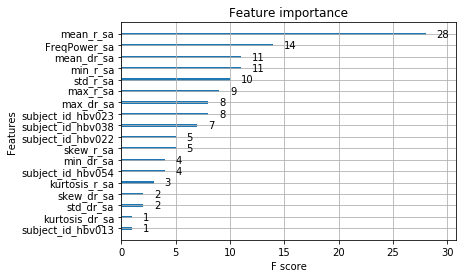

In [107]:
xgb.plot_importance(bst)


In [108]:
print("MSE XGB:" , str(metrics.mean_squared_error(y_test,xgb_pred)))
print("NULL XGB:", str(metrics.mean_squared_error(y_test, null_test)))

MSE XGB: 0.3422127392624023
NULL XGB: 0.4133438174743709


In [109]:
xgb_pred=np.round(xgb_pred)

In [110]:
print("accuracy xgb:", str(metrics.accuracy_score(y_test, xgb_pred)))
print("MSE XGB:" , str(metrics.mean_squared_error(y_test,xgb_pred)))
print("NULL XGB:", str(metrics.mean_squared_error(y_test, null_test)))

accuracy xgb: 0.7063636363636364
MSE XGB: 0.3936363636363636
NULL XGB: 0.4133438174743709


In [111]:
test['xgb_pred']=xgb_pred
test.head()

C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,measurement_id,mean_r_sa,std_r_sa,min_r_sa,max_r_sa,skew_r_sa,kurtosis_r_sa,mean_dr_sa,std_dr_sa,min_dr_sa,max_dr_sa,skew_dr_sa,kurtosis_dr_sa,FreqPower_sa,subject_id,tremor,tremor_null,xgb_pred
630,102fc3ed-5081-4e00-97b9-a434dc51281b,0.650802,-0.516883,0.800065,-0.556092,-0.125533,-0.194752,-0.432311,-0.554151,-0.326341,-0.554343,-0.628123,-0.339697,-0.510444,hbv038,2.0,2.046512,2.0
7499,aba31c29-79ef-4221-9412-156538a2fd4e,-0.894636,0.823161,-1.215850,1.184473,0.544554,-0.107047,0.248869,1.164159,-0.326341,1.306812,0.163943,-0.134810,1.211601,hbv012,1.0,0.428571,0.0
982,18627dda-3e46-44e6-9799-2c6cb1e23e95,-0.209574,-0.513429,0.742098,-0.578930,-0.130045,-0.201210,-0.352433,-0.556089,-0.326341,-0.549379,-0.585430,-0.333193,-0.454938,hbv013,2.0,0.373134,1.0
10652,f8986b3d-d77c-4c5e-af03-d2adc2c3e022,0.213892,0.379029,-1.274863,0.734231,0.228973,-0.147537,-0.197115,0.566288,-0.326341,0.497105,-0.134046,-0.238268,0.657383,hbv012,0.0,0.428571,0.0
9971,edc0b81f-1bb0-42cd-9346-92d7de4f50b0,2.924313,-0.386784,0.441005,-0.083111,2.188972,0.799146,-0.357874,-0.109461,0.288279,0.087316,1.376425,0.479006,-0.449703,hbv022,0.0,0.285714,0.0


In [112]:
results=pd.DataFrame(test.groupby('measurement_id', as_index=False).agg({'xgb_pred':np.mean, 'tremor':pd.Series.mode, 'tremor_null':pd.Series.mode}))

In [113]:
results['preds']=round(results['xgb_pred'])

In [114]:
metrics.mean_squared_error(results['tremor'], results['xgb_pred'])

0.34585492853812555

In [115]:
metrics.mean_squared_error(results['tremor'], results['tremor_null'])

0.3940974321488145

In [116]:
metrics.mean_squared_error(results['tremor'], results['preds'])

0.3811188811188811

In [117]:
metrics.accuracy_score(results['tremor'], results['preds'])

0.7237762237762237

In [118]:
print(metrics.classification_report(results['tremor'], results['preds']))

              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89       154
         1.0       0.53      0.19      0.28        48
         2.0       0.55      0.78      0.65        59
         3.0       1.00      0.04      0.08        25

    accuracy                           0.72       286
   macro avg       0.72      0.50      0.47       286
weighted avg       0.73      0.72      0.67       286



In [119]:
print(metrics.confusion_matrix(results['tremor'], results['preds']))

[[151   3   0   0]
 [ 25   9  14   0]
 [  9   4  46   0]
 [  0   1  23   1]]


In [120]:
stats=test.groupby('tremor', as_index=False).agg({'xgb_pred':[np.mean, np.std]})

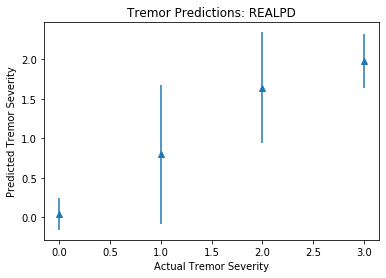

In [121]:
plt.errorbar(stats['tremor'], stats['xgb_pred']['mean'], stats['xgb_pred']['std'], linestyle='None', marker='^')
plt.title('Tremor Predictions: REALPD')
plt.xlabel('Actual Tremor Severity')
plt.ylabel('Predicted Tremor Severity')
plt.show()

### Testing (This section will not be updated until test labels are published)

In [ ]:
test_subjects = pd.read_csv('testing_data\REAL-PD_Test_Data_IDs.csv')
test_subjects.head()

In [ ]:
test_subjects.subject_id.unique()==labels.subject_id.unique()

In [ ]:

#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'testing_data\REAL_testing\smartphone_accelerometer'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means_sa=[]
for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    
    #Relevant features 
    measurement_id = os.path.basename(csvfile)
    measurement_id = measurement_id.replace(".csv","")
    
    df["r"] = np.sqrt(df.x**2+df.y**2+df.z**2)
    dr = np.sqrt(np.diff(df.x)**2+np.diff(df.y)**2+np.diff(df.z)**2)
    mean_r = np.median(df.r)
    std_r = np.std(df.r)
    min_r = np.min(df.r)
    max_r = np.max(df.r)
    skew_r = skew(df.r)
    kurtosis_r = kurtosis(df.r)
    
    mean_dr = np.median(dr)
    std_dr = np.std(dr)
    min_dr = np.min(dr)
    max_dr = np.max(dr)
    skew_dr = skew(dr)
    kurtosis_dr = kurtosis(dr)
    
    """Extract frequency bands in Hz"""
    FreqBandx = sig.lfilter(Filter[0],Filter[1],df["x"]);
    FreqBandy = sig.lfilter(Filter[0],Filter[1],df["y"]);
    FreqBandz = sig.lfilter(Filter[0],Filter[1],df["z"]);
    
    """Find the power in each frequency Band"""
    PowerFreqBandx = np.abs(FreqBandx)**2;
    PowerFreqBandy = np.abs(FreqBandy)**2;
    PowerFreqBandz = np.abs(FreqBandz)**2;
    
    """Sum the power in each frequency band"""
    SumPowerFreqBandx = np.sum(PowerFreqBandx);
    SumPowerFreqBandy = np.sum(PowerFreqBandy);
    SumPowerFreqBandz = np.sum(PowerFreqBandz);
    
    """Sum the total signal power"""
    Powerx = np.sum(df["x"]**2);
    Powery = np.sum(df["y"]**2);
    Powerz = np.sum(df["z"]**2);
    
    """Find the percentage of power in frequencies of interest"""
    FreqPower = np.sqrt((SumPowerFreqBandx+SumPowerFreqBandy+SumPowerFreqBandz)/(Powerx+Powery+Powerz));
    
    Means_sa.append([measurement_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r, 
                     mean_dr,std_dr, min_dr, max_dr, skew_dr, kurtosis_dr,FreqPower])

   

In [ ]:
accel_phones_test= pd.DataFrame(Means_sa, columns=["measurement_id", "mean_r_sa", "std_r_sa", 
                                              "min_r_sa", "max_r_sa", "skew_r_sa", "kurtosis_r_sa",
                                              "mean_dr_sa", "std_dr_sa", "min_dr_sa", "max_dr_sa", 
                                              "skew_dr_sa", "kurtosis_dr_sa","FreqPower_sa"])
   


In [ ]:
accel_phones_test.head()

In [ ]:

#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'testing_data\REAL_testing\smartwatch_accelerometer'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means_wa=[]
for csvfile in csvfiles:
    df1 = pd.read_csv(csvfile)
    
    for x in pd.Series(df1['device_id']).unique():
        
        df = df1[df1['device_id']==x]
        """Apply Hypothesis tests to check if means are statistically significant????"""
        #Relevant features 
        measurement_id = os.path.basename(csvfile)
        measurement_id = measurement_id.replace(".csv","")

        device_id = x
        
        df["r"] = np.sqrt(df.x**2+df.y**2+df.z**2)
        dr = np.sqrt(np.diff(df.x)**2+np.diff(df.y)**2+np.diff(df.z)**2)

        mean_r = np.mean(df.r)
        std_r = np.std(df.r)
        min_r = np.min(df.r)
        max_r = np.max(df.r)
        skew_r = skew(df.r)
        kurtosis_r = kurtosis(df.r)

        mean_dr = np.mean(dr)
        std_dr = np.std(dr)
        min_dr = np.min(dr)
        max_dr = np.max(dr)
        skew_dr = skew(dr)
        kurtosis_dr = kurtosis(dr)
        
        """Extract frequency bands in Hz"""
        FreqBandx = sig.lfilter(Filter[0],Filter[1],df["x"]);
        FreqBandy = sig.lfilter(Filter[0],Filter[1],df["y"]);
        FreqBandz = sig.lfilter(Filter[0],Filter[1],df["z"]);

        """Find the power in each frequency Band"""
        PowerFreqBandx = np.abs(FreqBandx)**2;
        PowerFreqBandy = np.abs(FreqBandy)**2;
        PowerFreqBandz = np.abs(FreqBandz)**2;

        """Sum the power in each frequency band"""
        SumPowerFreqBandx = np.sum(PowerFreqBandx);
        SumPowerFreqBandy = np.sum(PowerFreqBandy);
        SumPowerFreqBandz = np.sum(PowerFreqBandz);

        """Sum the total signal power"""
        Powerx = np.sum(df["x"]**2);
        Powery = np.sum(df["y"]**2);
        Powerz = np.sum(df["z"]**2);

        """Find the percentage of power in frequencies of interest"""
        FreqPower = np.sqrt((SumPowerFreqBandx+SumPowerFreqBandy+SumPowerFreqBandz)/(Powerx+Powery+Powerz));

        Means_wa.append([measurement_id, device_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r, 
                         mean_dr,std_dr, min_dr, max_dr, skew_dr, kurtosis_dr,FreqPower])


    
        

In [ ]:
accel_watches_test = pd.DataFrame(Means_wa, columns=["measurement_id","device_id", "mean_r_wa", "std_r_wa", 
                                              "min_r_wa", "max_r_wa", "skew__r_wa", "kurtosis_r_wa",
                                              "mean_dr_wa", "std_dr_wa", "min_dr_wa", "max_dr_Wa", 
                                              "skew_dr_wa", "kurtosis_dr_wa","FreqPower_wa"])
   



In [ ]:
#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'testing_data\REAL_testing\smartwatch_gyroscope'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means_wg=[]
for csvfile in csvfiles:
    df1 = pd.read_csv(csvfile)
    
    for x in pd.Series(df1['device_id']).unique():
        
        df = df1[df1['device_id']==x]
         
        #Relevant features 
        measurement_id = os.path.basename(csvfile)
        measurement_id = measurement_id.replace(".csv","")
        device_id = x

        df["r"] = np.sqrt(df.x**2+df.y**2+df.z**2)
        mean_r = np.mean(df.r)
        std_r = np.std(df.r)
        min_r = np.min(df.r)
        max_r = np.max(df.r)
        skew_r = skew(df.r)
        kurtosis_r = kurtosis(df.r)
    
        Means_wg.append([measurement_id,device_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r])
       

In [ ]:
gyro_watches_test= pd.DataFrame(Means_wg, columns=["measurement_id", "device_id", "mean_r_wg", "std_r_wg", 
                                              "min_r_wg", "max_r_wg", "skew_r_wg", "kurtosis_r_wg"])
   



In [ ]:
df_watch_test=pd.merge(gyro_watches_test, accel_watches_test, on=["measurement_id", "device_id"])
df_watch_test.shape

In [ ]:
df_test=pd.merge(df_watch_test, accel_phones_test, on=['measurement_id'], how='outer')
df_test.shape

In [ ]:
df_test_data = pd.merge(df_test, test_subjects, on =['measurement_id'])
df_test_data.shape

In [ ]:
df_test_data.subject_id.unique()

In [ ]:
train = df_tremor.drop(['measurement_id', 'device_id', 'tremor', 'tremor_null'], axis=1)
train.head()

In [ ]:
cols_train = train.columns[:-1]
scaler= scaler.fit(df_tremor[cols_train])
train[cols_train] = scaler.transform(train[cols_train])
train.head()

In [ ]:
cols_test=df_test_data.columns[2:-1]
df_test_data[cols_test]=scaler.transform(df_test_data[cols_test])

In [ ]:
df_test_data.head()

In [ ]:
train = pd.get_dummies(train)

In [ ]:

df_test_predict= pd.get_dummies(df_test_data[df_test_data.columns[2:]])
df_test_predict.head()

In [ ]:
df_test_data.subject_id.unique()

In [ ]:
df_tremor.subject_id.unique()

In [ ]:
df_test_predict = df_test_predict.drop(['subject_id_hbv051', 'subject_id_hbv077', 'subject_id_hbv018', 
                      'subject_id_hbv043', 'subject_id_hbv014', 'subject_id_hbv017'], 
                    axis = 1)


In [ ]:
df_test_predict.shape

In [ ]:
df_train_imputed = pd.DataFrame(imputer.fit_transform(train), columns = train.columns)
df_train_imputed.shape

In [ ]:
df_test_imputed=pd.DataFrame(imputer.fit_transform(df_test_predict), columns = df_test_predict.columns)
df_test_imputed.shape

In [ ]:
dtrain=xgb.DMatrix(data=df_train_imputed, label=df_tremor.tremor)
dtest = xgb.DMatrix(data=df_test_imputed)

In [ ]:
bst = xgb.train(param, dtrain)
xgb_pred = bst.predict(dtest)

In [ ]:

df_test_data["prediction"]=xgb_pred
df_test_data.head()

In [ ]:
test_subjects.shape

In [ ]:
df_predictions = pd.merge(df_test_data[['measurement_id', 'prediction']], test_subjects, on=['measurement_id'], how ="right")

In [ ]:
len(df_predictions.measurement_id.unique())

In [ ]:
df_predictions.shape

In [ ]:
df_predictions.drop_duplicates(subset ="measurement_id", inplace=True) 

In [ ]:
df_predictions.shape

In [ ]:
df_predictions.head()

In [ ]:
df_predictions[['measurement_id','prediction']].to_csv("real_pd_tremor_predictions.csv", index=False)